# Chroma Patch Matching via 2D Fourier Transform Magnitude

Beat-synchronous chroma matrices provide a rich representation of the tonal/harmonic content of a musical excerpt.  It would be interesting to find all near-neighbors of a given patch of beat-synchronous chroma.  But because a chroma patch of, say, 32 beats, can start at any beat offset (not to mention possible transposition differences) a direct search could quickly become very computationally expensive.

To reduce the computational expense, representing each patch by its 2D Fourier Transform Magnitude allows patches to match even despite rotations on the chroma axis (which appear only as differences in phase of the 2D Fourier Transform, without affecting its magnitude) and, unlike direct comparisons, is tolerant of small shifts in the time base, since provided most of the "structure" stays within the analyzed patch, the exact temporal position of that structure is again only encoded in the phase, and is not reflected in the magnitude.  Discarding all the phase actually matches many distortions beyond simple circular translations, but in practice these other transformations (corresponding to shifting distinct Fourier components by different amounts) may not give plausible beat-chroma patches, so don't lead to many false matches.

A second computational reduction comes from representing a higher-dimensional beat-chroma patch via a smaller number of principal components - basis vectors in the original beat-chroma patch space that can account for the greatest amount of variation in the actual data set.  Thus, a 384-dimensional comparison between two 12x32 chroma patches can be reduced to, say, comparing two 20-dimensional vectors of principal components.

This notebook explores representing a collection of songs described by their beat-chroma arrays as the PCA projection of the 2D Fourier Transform Magnitudes (2DFTM) of 32 beat patches sampled every two beats.  These techniques allow approximate matching between all the 32-beat chroma subpatches in the corpus.

This notebook was initially developed as a practical for the course ELEN E4896 Music Signal Processing, but in the event I never got it working well enough to use in class.

In [1]:
%pylab inline
from __future__ import print_function

import cPickle as pickle
import os
import time
import IPython

import numpy as np
import scipy

import librosa

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [2]:
def read_beat_chroma_labels(filename):
    """Read back a precomputed beat-synchronous chroma record."""
    with open(filename, "rb") as f:
        beat_times, chroma_features, label_indices = pickle.load(f)
    return beat_times, chroma_features, label_indices

def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', origin='bottom', cmap='gray_r', **kwargs)

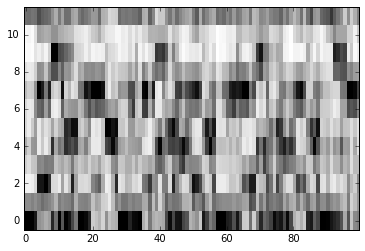

In [3]:
DATA_DIR = '/Users/dpwe/Downloads/prac10/data/'
file_id = 'beatles/Let_It_Be/06-Let_It_Be'

beat_times, chroma, label_indices = read_beat_chroma_labels(os.path.join(DATA_DIR, 'beatchromlabs', file_id + '.pkl'))

my_imshow(chroma[:100].transpose())

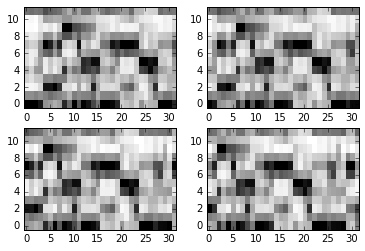

In [4]:
# Make an array of all the possible 32-beat patches within the full chroma matrix
# at every possible 2 beat offset.  Do this with stride tricks to avoid blowing up 
# the representation by 16x.
frame_length = 32
frame_hop = 2
item_bytes = chroma.itemsize
num_beats, num_chroma = chroma.shape
frame_starts = np.arange(0, num_beats - frame_length, frame_hop)
num_frames = len(frame_starts)
chroma_frames = np.lib.stride_tricks.as_strided(
  chroma, strides=(frame_hop * num_chroma * item_bytes, 
                   num_chroma * item_bytes, item_bytes), 
  shape=(num_frames, frame_length, num_chroma))
# Check that each slice shows an overlapping patch.
for i in xrange(4):
    subplot(2,2,i+1)
    my_imshow(chroma_frames[i].transpose())


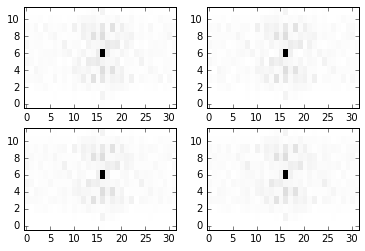

In [5]:
# Show that we can calculate the 2DFTM for each patch, and that they are all quite 
# similar despite time shifts.
features = np.abs(np.fft.fft2(chroma_frames))
for i in xrange(4):
    subplot(2,2,i+1)
    my_imshow(np.fft.fftshift(features[i].transpose()))

In [6]:
from sklearn.decomposition import PCA

[ 0.19906312  0.33528574  0.45462259  0.54418604  0.5993832   0.64424039
  0.68062326  0.70714349  0.73060561  0.75257363  0.77258905  0.78996079
  0.8063029   0.8207345   0.8344319   0.84596767  0.85656317  0.86520144
  0.87352862  0.88097102]


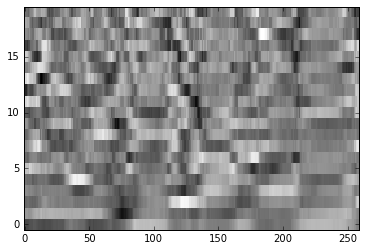

In [7]:
# Calculate 20-dimensional PCA features for this set of chroma 2DFTM patches, unraveled into 384-point vectors.
pca = PCA(n_components=20, whiten=True, copy=True)
flat_features = np.reshape(features, (features.shape[0], features.shape[1]*features.shape[2]))
pca.fit(flat_features)
# Show how the succession of overlapping patches results in relatively slowly-changing PCA projections.
my_imshow(pca.transform(flat_features).transpose())
print(np.cumsum(pca.explained_variance_ratio_))

In [8]:
# Run the separate code to build an entire matrix of beat-chroma-PCA.
os.chdir('/Users/dpwe/Downloads/e4896/elene4896/prac_matchchroma')
import match_chroma

(15740, 192)


In [9]:
reload(match_chroma)

(15740, 192)


<module 'match_chroma' from 'match_chroma.pyc'>

In [11]:
# We can quickly find all the near neighbors for each pattern 
# by putting all the points into a KDTree.

import sklearn.neighbors
kd_tree = sklearn.neighbors.KDTree(match_chroma.all_features)

def find_best_match(tree, query_index, search_depth=20):
    query_id = match_chroma.all_ids[query_index]
    distances, indices = tree.query(match_chroma.all_features[[query_index]], k=search_depth)
    for index_, distance in zip(indices[0], distances[0]):
        if match_chroma.all_ids[index_] is not query_id:
            break
    if match_chroma.all_ids[index_] == query_id:
        return None, None
    else:
        return index_, distance
    
best_query = None
best_distance = 999.0
for i in xrange(match_chroma.all_features.shape[0]):
    best_match, distance = find_best_match(kd_tree, i)
    if distance is not None and distance < 1.0:
        print(i, best_match, distance)

4324 5837 0.828465229879
4325 5837 0.768369178064
5026 6796 0.9011683911
5027 6796 0.905756468331
5028 6795 0.91796302999
5460 9798 0.910378612482
5461 9803 0.861198979036
5837 4325 0.768369178064
6795 5028 0.91796302999
6796 5026 0.9011683911
6798 5026 0.978451240359
6809 9805 0.795637556115
8457 15221 0.973641765491
8515 9381 0.891466593421
9381 8515 0.891466593421
9797 5460 0.943167912254
9798 5460 0.910378612482
9799 5460 0.917668286341
9800 5460 0.979629143015
9803 5461 0.861198979036
9805 6809 0.795637556115
15213 15576 0.9388530975
15221 8457 0.973641765491
15576 15213 0.9388530975


In [12]:
# Choose one of the near-neighbors we found, re-retrieve its nearest neighbor, check the distance is small.
best_query = 4324
best_match, distance = find_best_match(kd_tree, best_query)
print(best_match, distance)

5837 0.828465229879


(86784,)


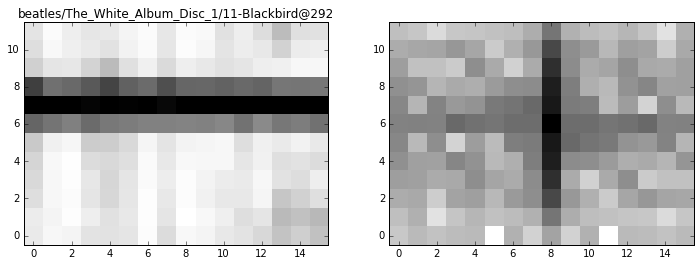

In [13]:
# Plot the chroma array (and its 2DFTM) for the source pattern, and extract the corresponding audio.

def show_chroma(index, frame_length=16):
    track = match_chroma.all_ids[index]
    start = match_chroma.all_starts[index]
    beat_times, chroma, _ = match_chroma.read_beat_chroma_labels_for_id(track)
    chroma_patch = chroma[start : start + frame_length]
    subplot(121)
    my_imshow(chroma_patch.transpose())
    title(track + "@" + str(start))
    subplot(122)
    fftm_patch = np.fft.fftshift(np.abs(np.fft.fft2(chroma_patch.transpose())))
    my_imshow(np.log10(fftm_patch))
    wavfile = os.path.join(DATA_DIR, 'mp3s-32k', track + '.mp3')
    y, sr = librosa.load(wavfile, sr=None)
    return y[int(sr * beat_times[start]):int(sr * beat_times[start + frame_length])], sr, fftm_patch

plt.figure(figsize=(12,4))
y, sr, patch0 = show_chroma(best_query)
print(y.shape)
IPython.display.Audio(data=y, rate=sr)


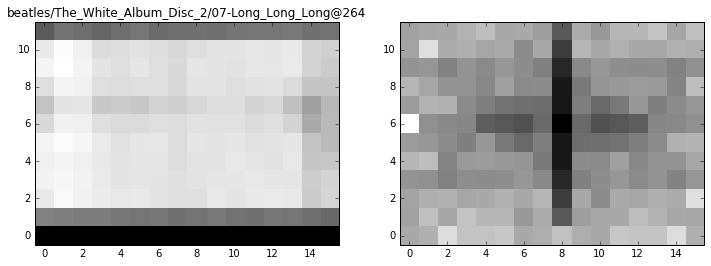

In [14]:
# Plot the chroma patch, 2DFTM, and audio excerpt of the nearest neighbor.
plt.figure(figsize=(12,4))
y, sr, patch1 = show_chroma(best_match)
IPython.display.Audio(data=y, rate=sr)

In [99]:
# Below here is just a scratch pad for trying to find more interesting near-neighbor pairs.
print(match_chroma.all_ids.index('beatles/Let_It_Be/06-Let_It_Be'))

6971


In [154]:
print(np.sqrt(np.sum((patch0 - patch1)**2)))

83.6580562906


In [156]:
print(np.sqrt(np.sum((match_chroma.all_features[6971] - match_chroma.all_features[1877])**2)))

39.5936114631


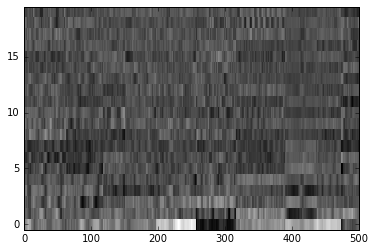

In [157]:
my_imshow(match_chroma.all_features[0:500].transpose())

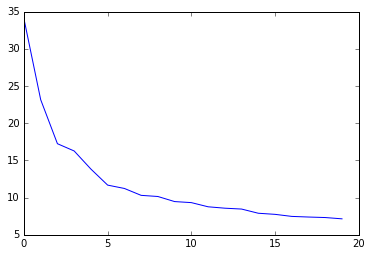

In [158]:
plot(np.std(match_chroma.all_features, axis=0))

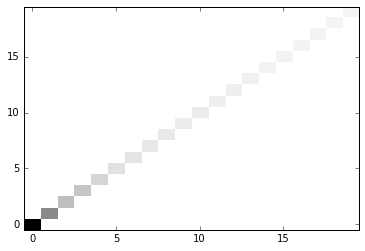

In [159]:
my_imshow(np.cov(match_chroma.all_features, rowvar=0))

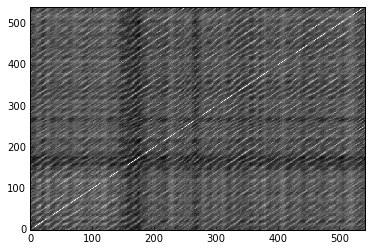

In [209]:
framed_array, starts = match_chroma.frame_array(read_beat_chroma_labels(os.path.join(DATA_DIR, 'beatchromlabs', file_id + '.pkl'))[1], frame_length=8, frame_hop=1)
flattened_array = np.reshape(framed_array, (framed_array.shape[0], framed_array.shape[1]*framed_array.shape[2]))
my_imshow(sklearn.metrics.pairwise.pairwise_distances(flattened_array))